In [4]:
!pip install --quiet kagglehub tensorflow==2.12.0
!pip install --quiet tensorflow-addons pillow tqdm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.12.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.12.0
ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [5]:
import os
import random
import shutil
import glob
from pathlib import Path
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reproducibility (best-effort)
SEED = 42
random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
try:
    import kagglehub
    print("kagglehub imported — attempting dataset download...")
    path = kagglehub.dataset_download("owlxiaoliu/four-binary-classification-datasets-of-faces")
    # kagglehub may return a path to extracted folder or to a zip; handle both
    print("Path to dataset files (kagglehub):", path)
except Exception as e:
    print("kagglehub download failed:", e)
    print("\nIf kagglehub can't download, either (A) install/authorize Kaggle CLI and use it, or")
    print("(B) manually upload the dataset to Colab and set `DATASET_ROOT` below to that folder.")
    raise

kagglehub imported — attempting dataset download...


100%|██████████| 4.39G/4.39G [00:51<00:00, 91.2MB/s]

Extracting files...


Path to dataset files (kagglehub): /root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1


In [7]:
root = Path(path)
candidates = list(root.rglob("RealHumanHairColor/RealHumanHairColor")) + list(root.rglob("RealHumanHairColor"))
# Filter directories that contain subdirs Color and WhiteBlack
dataset_dir = None
for cand in candidates:
    cand = Path(cand)
    if (cand / "Color").is_dir() and (cand / "WhiteBlack").is_dir():
        dataset_dir = cand
        break

if dataset_dir is None:
    # try a fallback (some datasets might extract to a different path)
    possible = list(root.rglob("*RealHumanHairColor*"))
    found = [(p, p.is_dir()) for p in possible]
    print("Couldn't confidently find RealHumanHairColor/RealHumanHairColor automatically.")
    print("Candidates found:", found[:10])
    raise FileNotFoundError("Please set dataset_dir manually: edit the script to point to the dataset folder containing 'Color' and 'WhiteBlack' subfolders.")

print("Using dataset directory:", dataset_dir.resolve())
color_dir = dataset_dir / "Color"
white_dir = dataset_dir / "WhiteBlack"

print("Color count:", len(list(color_dir.glob("*"))))
print("WhiteBlack count:", len(list(white_dir.glob("*"))))

Using dataset directory: /root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1/RealHumanHairColor/RealHumanHairColor
Color count: 29983
WhiteBlack count: 48472


In [8]:
TARGET_PER_CLASS = 10000

def prune_folder_to_n(folder: Path, n: int, seed=SEED):
    files = [p for p in folder.iterdir() if p.is_file()]
    total = len(files)
    print(f"{folder} -> {total} files found.")
    if total <= n:
        print(f" <= {n} files, nothing to delete.")
        return total
    # randomly select n to keep, delete the rest
    random.Random(seed).shuffle(files)
    keep = set(files[:n])
    delete = [p for p in files if p not in keep]
    print(f"Deleting {len(delete)} files to keep only {n} files.")
    for p in tqdm(delete):
        try:
            p.unlink()
        except Exception as ex:
            print("Failed to delete", p, ex)
    return n

# prune both directories
count_color_after = prune_folder_to_n(color_dir, TARGET_PER_CLASS)
count_white_after = prune_folder_to_n(white_dir, TARGET_PER_CLASS)

print("After pruning — Color:", count_color_after, "WhiteBlack:", count_white_after)

/root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1/RealHumanHairColor/RealHumanHairColor/Color -> 29983 files found.
Deleting 19983 files to keep only 10000 files.


100%|██████████| 19983/19983 [00:00<00:00, 47376.03it/s]


/root/.cache/kagglehub/datasets/owlxiaoliu/four-binary-classification-datasets-of-faces/versions/1/RealHumanHairColor/RealHumanHairColor/WhiteBlack -> 48472 files found.
Deleting 38472 files to keep only 10000 files.


100%|██████████| 38472/38472 [00:00<00:00, 43900.49it/s]


After pruning — Color: 10000 WhiteBlack: 10000


In [9]:
from math import floor

BALANCED_ROOT = Path("dataset_balanced_haircolor")
if BALANCED_ROOT.exists():
    print("Balanced root already exists. Deleting and recreating to ensure a fresh start.")
    shutil.rmtree(BALANCED_ROOT)
(BALANCED_ROOT / "train").mkdir(parents=True, exist_ok=True)
(BALANCED_ROOT / "val").mkdir(parents=True, exist_ok=True)
(BALANCED_ROOT / "test").mkdir(parents=True, exist_ok=True)

classes = {"Color": color_dir, "WhiteBlack": white_dir}
split_ratios = {"train": 0.8, "val": 0.1, "test": 0.1}

for cls_name, src_dir in classes.items():
    files = [p for p in src_dir.iterdir() if p.is_file()]
    files = sorted(files)  # deterministic order then shuffle
    random.Random(SEED).shuffle(files)
    n = len(files)
    n_train = int(n * split_ratios["train"])
    n_val = int(n * split_ratios["val"])
    n_test = n - n_train - n_val
    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:],
    }
    for split_name, flist in splits.items():
        target_dir = BALANCED_ROOT / split_name / cls_name
        target_dir.mkdir(parents=True, exist_ok=True)
        for src in flist:
            dst = target_dir / src.name
            shutil.copy2(src, dst)
    print(f"Class {cls_name}: total={n}, train={n_train}, val={n_val}, test={n_test}")

print("Balanced dataset ready at:", BALANCED_ROOT.resolve())

Class Color: total=10000, train=8000, val=1000, test=1000
Class WhiteBlack: total=10000, train=8000, val=1000, test=1000
Balanced dataset ready at: /content/dataset_balanced_haircolor


In [10]:
IMG_SIZE = (100, 100)   # UPDATED to 100 x 100 as you requested
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BALANCED_ROOT / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BALANCED_ROOT / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=SEED
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    BALANCED_ROOT / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed=SEED
)

# performance
def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Found 16000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
from tensorflow.keras import Sequential, Input

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.06),
    layers.RandomContrast(0.06),
], name="data_augmentation")

def make_model(img_size=IMG_SIZE+(3,), dropout_rate=0.3):
    # img_size will be (100,100,3)
    inputs = Input(shape=img_size)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Convolutional blocks
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model

model = make_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,297 (434.75 KB)

 Trainable params: 110,593 (432.00 KB)

 Non-trainable params: 704 (2.75 KB)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
)

checkpoint_path = "best_haircolor_model.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_auc", mode="max", save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", patience=8, mode="max", restore_best_weights=True, verbose=1),
]

In [14]:
import numpy as np
from pathlib import Path

def compute_class_weights(base_dir: Path):
    train_dir = Path(base_dir) / "train"
    if not train_dir.exists():
        raise FileNotFoundError(f"Train directory not found at {train_dir}")

    # image_dataset_from_directory uses sorted alphabetical order of subfolder names for labels
    class_dirs = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
    if len(class_dirs) == 0:
        raise ValueError(f"No class subdirectories found in {train_dir}")

    counts = {}
    for cls in class_dirs:
        n = len(list((train_dir / cls).glob("*")))
        counts[cls] = n

    print("Detected class names (alphabetical order):", class_dirs)
    print("Train counts by class:", counts)

    freq = np.array([counts[cls] for cls in class_dirs], dtype=float)
    if np.any(freq == 0):
        # avoid division by zero; warn and set zero-class weight to 1.0
        zero_idxs = np.where(freq == 0)[0].tolist()
        print(f"Warning: found class(es) with zero samples at indices {zero_idxs}. Setting their weight to 1.0.")
        freq[freq == 0] = 1.0

    total = freq.sum()
    class_weight = {i: float(total / (len(freq) * freq[i])) for i in range(len(freq))}
    # Print mapping index -> class for clarity
    idx_to_class = {i: class_dirs[i] for i in range(len(class_dirs))}
    print("Index -> class mapping:", idx_to_class)
    print("Computed class weights (index: weight):", class_weight)
    return class_weight

# compute and store
class_weight = compute_class_weights(BALANCED_ROOT)
print("Class weights (for training):", class_weight)

Detected class names (alphabetical order): ['Color', 'WhiteBlack']
Train counts by class: {'Color': 8000, 'WhiteBlack': 8000}
Index -> class mapping: {0: 'Color', 1: 'WhiteBlack'}
Computed class weights (index: weight): {0: 1.0, 1: 1.0}
Class weights (for training): {0: 1.0, 1: 1.0}


In [15]:
EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8052 - auc: 0.8802 - loss: 0.4329
Epoch 1: val_auc improved from -inf to 0.95861, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - accuracy: 0.8053 - auc: 0.8804 - loss: 0.4327 - val_accuracy: 0.7445 - val_auc: 0.9586 - val_loss: 0.5285 - learning_rate: 1.0000e-04
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9222 - auc: 0.9750 - loss: 0.1999
Epoch 2: val_auc improved from 0.95861 to 0.98686, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9222 - auc: 0.9750 - loss: 0.1999 - val_accuracy: 0.9360 - val_auc: 0.9869 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 3/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9403 - auc: 0.9844 - loss: 0.1561
Epoch 3: val_auc improved from 0.98686 to 0.98902, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9403 - auc: 0.9844 - loss: 0.1561 - val_accuracy: 0.9550 - val_auc: 0.9890 - val_loss: 0.1482 - learning_rate: 1.0000e-04
Epoch 4/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9501 - auc: 0.9873 - loss: 0.1393
Epoch 4: val_auc improved from 0.98902 to 0.99179, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9501 - auc: 0.9873 - loss: 0.1392 - val_accuracy: 0.9710 - val_auc: 0.9918 - val_loss: 0.0989 - learning_rate: 1.0000e-04
Epoch 5/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9553 - auc: 0.9894 - loss: 0.1258
Epoch 5: val_auc improved from 0.99179 to 0.99193, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9553 - auc: 0.9894 - loss: 0.1257 - val_accuracy: 0.9720 - val_auc: 0.9919 - val_loss: 0.0941 - learning_rate: 1.0000e-04
Epoch 6/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9563 - auc: 0.9910 - loss: 0.1158
Epoch 6: val_auc improved from 0.99193 to 0.99261, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9563 - auc: 0.9910 - loss: 0.1158 - val_accuracy: 0.9675 - val_auc: 0.9926 - val_loss: 0.1077 - learning_rate: 1.0000e-04
Epoch 7/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9615 - auc: 0.9922 - loss: 0.1062
Epoch 7: val_auc did not improve from 0.99261
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9615 - auc: 0.9922 - loss: 0.1062 - val_accuracy: 0.9675 - val_auc: 0.9915 - val_loss: 0.1078 - learning_rate: 1.0000e-04
Epoch 8/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9627 - auc: 0.9927 - loss: 0.1022
Epoch 8: val_auc improved from 0.99261 to 0.99306, saving model to best_haircolor_model.h5



Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9627 - auc: 0.9927 - loss: 0.1022 - val_accuracy: 0.9655 - val_auc: 0.9931 - val_loss: 0.1007 - learning_rate: 1.0000e-04
Epoch 9/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9670 - auc: 0.9933 - loss: 0.0933
Epoch 9: val_auc improved from 0.99306 to 0.99534, saving model to best_haircolor_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9670 - auc: 0.9934 - loss: 0.0933 - val_accuracy: 0.9825 - val_auc: 0.9953 - val_loss: 0.0645 - learning_rate: 5.0000e-05
Epoch 10/10
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9701 - auc: 0.9944 - loss: 0.0852
Epoch 10: val_auc did not improve from 0.99534
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9701 - auc: 0.9944 - loss: 0.0852 - val_accuracy: 0.9810 - val_auc: 0.9952 - val_loss: 0.0726 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.


In [16]:
from tensorflow.keras.models import load_model
best_model = load_model(checkpoint_path)
print("Evaluating on test set...")
results = best_model.evaluate(test_ds, verbose=1)
for name, val in zip(best_model.metrics_names, results):
    print(f"{name}: {val:.4f}")

Evaluating on test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9820 - auc: 0.9975 - loss: 0.0515
loss: 0.0513
compile_metrics: 0.9825


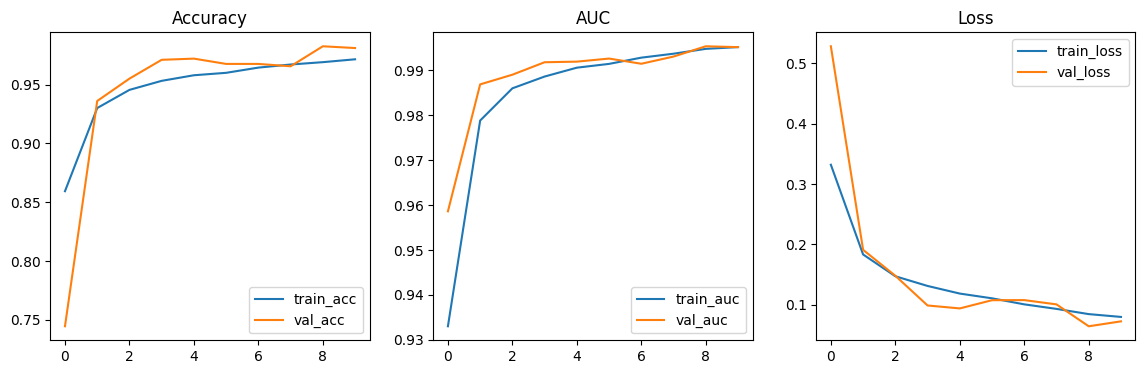

In [17]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(history_dict.get("accuracy", []), label="train_acc")
plt.plot(history_dict.get("val_accuracy", []), label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history_dict.get("auc", []), label="train_auc")
plt.plot(history_dict.get("val_auc", []), label="val_auc")
plt.title("AUC")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history_dict.get("loss", []), label="train_loss")
plt.plot(history_dict.get("val_loss", []), label="val_loss")
plt.title("Loss")
plt.legend()

plt.show()